**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

# Setup

In [ ]:
!pip install scikeras[tensorflow]

In [121]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasRegressor

import seaborn as sns, pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

In [ ]:
X = dict()
y = dict()

# Utils

In [29]:
def plot_random_items(n_cols = 3, n_rows = 3, cmap = 'binary',class_names = 
                      ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
                      ,model=None, split = 'train'):
    figure = plt.figure(figsize=(10, 10))
    for i in range(1, n_cols * n_rows + 1):
        sample_idx = np.random.randint(X[split].shape[0],size=(1,))[0]
        figure.add_subplot(n_rows, n_cols, i)
        _title = class_names[y[split][sample_idx]] if model is None \
        else f'''
        True:{class_names[y[split][sample_idx]]}
        Pred: {class_names[
                           np.argmax(model.predict(np.expand_dims(X[split][sample_idx],axis=0)),axis=-1)[0]]}'''
        plt.title(_title)
        plt.axis("off")
        plt.imshow(X[split][sample_idx], cmap=cmap, interpolation='nearest')
    plt.show()

def plot_regr_loss(history):
    fig = make_subplots(
                        rows=1,cols=1,
                        subplot_titles=['Loss']
                        )
    x_s = np.arange(1, len(history.history['loss']) + 1)

    fig.append_trace(go.Scatter(
                            x = x_s,
                            y=history.history['loss'],
                            name='train',
                            mode='lines+markers'), row=1,col=1)
    fig.add_trace(go.Scatter(
                            x = x_s,
                            y=history.history['val_loss'],
                            name='val',
                            mode='lines+markers'), row=1,col=1)

    fig.update_xaxes(title_text='Epoch')
    fig.update_yaxes(title_text='Loss',row=1,col=1)
    return fig

get_run_logdir = lambda root_logdir: os.path.join(root_logdir,
                                                  time.strftime('run_%H:%M:%S_%d_%m_%Y'))

# Fashion MNIST Classifier



## Data

In [31]:
n_classes = 10 # 10 item names

(X['train'], y['train']), (X['test'], y['test']) = keras.datasets.fashion_mnist.load_data()
X['train'], X['test'] = (X.astype('float32')/255 for X in (X['train'], X['test']))


In [32]:
print(f"""
X shape:{X['test'].shape[1:]}
y shape: 1
Dtype: {X['test'].dtype}
{'-'*54}""")

for split in X.keys():
    print(f"""{split.capitalize()}: {y[split].shape[0]}""")


X shape:(28, 28)
y shape: 1
Dtype: float32
------------------------------------------------------
Train: 60000
Test: 10000


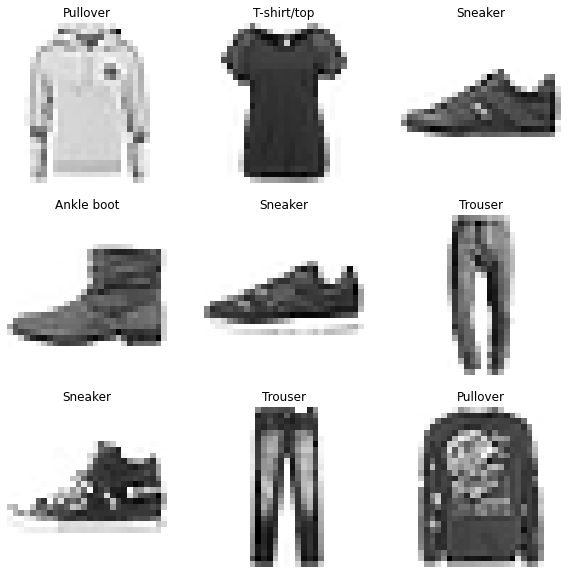

In [33]:
plot_random_items(split = 'train')

## Model

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=X['test'].shape[1:]),
    keras.layers.Dense(350, activation = 'relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(n_classes, activation='softmax')]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 350)               274750    
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               35100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 310,860
Trainable params: 310,860
Non-trainable params: 0
_________________________________________________________________


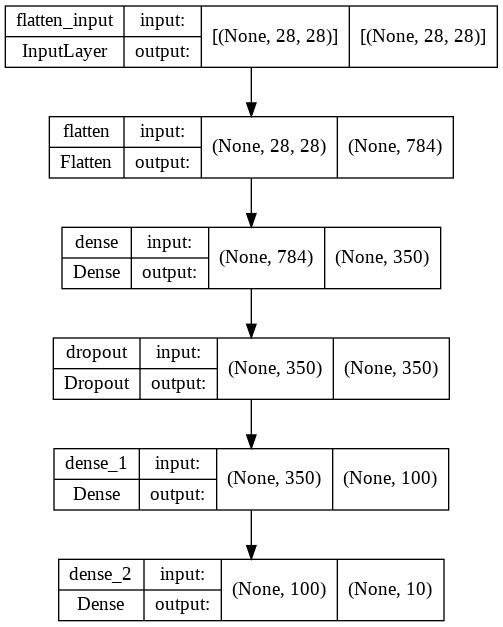

In [ ]:
plot_model(model,show_shapes=True,show_dtype=not True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [ ]:
history = model.fit(X['train'],y['train'],
          validation_split = 0.7,
          epochs = 30,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=3)])

In [ ]:

fig = make_subplots(
                    rows=1,cols=2,
                    subplot_titles=['Accuracy graph'*0,'Loss graph'*0]
                    )

fig.append_trace(go.Scatter(
                         y=history.history['accuracy'],
                         name='train accuracy',
                         mode='lines+markers',
                         legendgroup = 1),
              row=1,col=1)
fig.append_trace(go.Scatter(
                         y=history.history['val_accuracy'],
                         name='val accuracy',
                         mode='lines+markers',
                         legendgroup = 1),
              row=1,col=1)

fig.append_trace(go.Scatter(
                         y=history.history['loss'],
                         name='train loss',
                         mode='lines+markers',
                         legendgroup=2),
              row=1,col=2)
fig.append_trace(go.Scatter(
                         y=history.history['val_loss'],
                         name='val loss',
                         mode='lines+markers',
                         legendgroup=2),
              row=1,col=2)

fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='Accuracy',row=1,col=1)
fig.update_yaxes(title_text='Loss',row=1,col=2)
fig.update_layout(legend = {'orientation':'h',
                            'xanchor':'left',
                            'yanchor':'top',
                            'x':0,
                            'y':1.2},)

In [ ]:
weights, biases = model.layers[1].get_weights()
print(f"""Fully Connected[1]:
weights shape: {weights.shape}
biases shape: {biases.shape}
""")

Fully Connected[1]:
weights shape: (784, 350)
biases shape: (350,)



In [ ]:
model.evaluate(X['test'],y['test'])

313/313 [==============================] - 1s 4ms/step - loss: 0.3698 - accuracy: 0.8737
[0.36975473165512085, 0.8737000226974487]


In [ ]:
k = 2
X_new = np.expand_dims(X['test'][k],axis=0)
print(X_new.shape)
predictions = np.argmax(model.predict(X_new),axis=-1)
for i in range(1):
    print(f"""Predicted label: {class_names[predictions[i]]}
    Actual label: {class_names[y['test'][k]]}""")

(1, 28, 28)
Predicted label: Trouser
    Actual label: Trouser


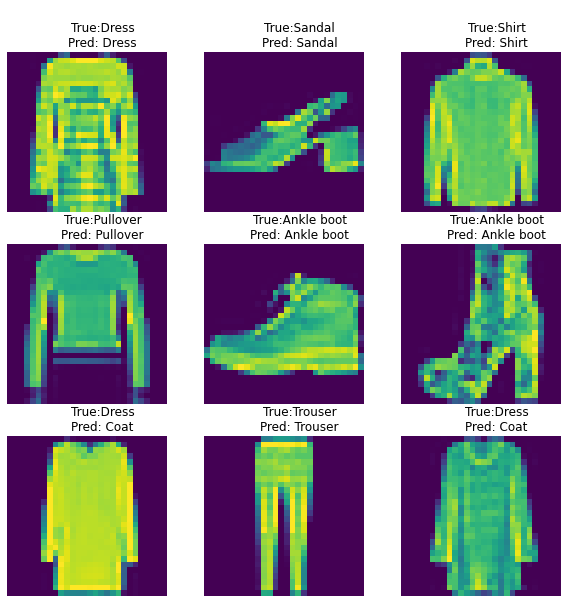

In [ ]:
plot_random_items(split = 'test', model = model, cmap='viridis')

# Housing Regression

## Data

In [47]:
keras.backend.clear_session()

In [49]:
housing = fetch_california_housing()

n_features = housing['data'].shape[1:]

housing.data.shape

(20640, 8)

In [50]:
X['train'], X['test'], y['train'], y['test'] = train_test_split(housing['data'], housing['target'], test_size=0.3, shuffle=True)
X['train'].shape[0], X['test'].shape[0]

(14448, 6192)

In [51]:
scaler = StandardScaler()
X['train'] = scaler.fit_transform(X['train'])
X['test'] = scaler.transform(X['test'])

## Model

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.Dense(50,input_shape=n_features, activation='relu'),
                                 keras.layers.Dropout(.2),
                                 keras.layers.Dense(25,input_shape=n_features, activation='relu'),
                                 keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=1e-3))
#plot_model(model,show_shapes=True)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 50)                450       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 25)                1275      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,751
Trainable params: 1,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X['train'],y['train'],
          validation_split = 0.7,
          epochs = 100,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

In [ ]:


plot_regr_loss(history)

In [ ]:
model.evaluate(X['train'],batch_size=16)

903/903 [==============================] - 2s 2ms/step - loss: 0.0000e+00


0.0

## Regression with Functional API

### Wide & Deep

In [ ]:
num_hiddens = 3
input_layer = keras.layers.Input(shape=X['train'].shape[1:])
hidden_layer = keras.layers.Dense(30,activation='relu')(input_layer)

for i in range(1, num_hiddens):
    hidden_layer = keras.layers.Dense(30,activation='relu')(hidden_layer)
    hidden_layer = keras.layers.Dropout(0.2)(hidden_layer)

output_layer = keras.layers.Dense(1)(
    keras.layers.concatenate([input_layer, hidden_layer])
)

model = keras.models.Model(inputs=[input_layer],
                           outputs=[output_layer])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 dense_46 (Dense)               (None, 30)           270         ['input_12[0][0]']               
                                                                                                  
 dense_47 (Dense)               (None, 30)           930         ['dense_46[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 30)           0           ['dense_47[0][0]']               
                                                                                            

In [ ]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3))

history = model.fit(X['train'],y['train'],
          validation_split = 0.3,
          epochs = 100,
          batch_size=128,
          callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

In [ ]:
plot_regr_loss(history)

###Wide & Deep with 2 inputs, 2 outputs

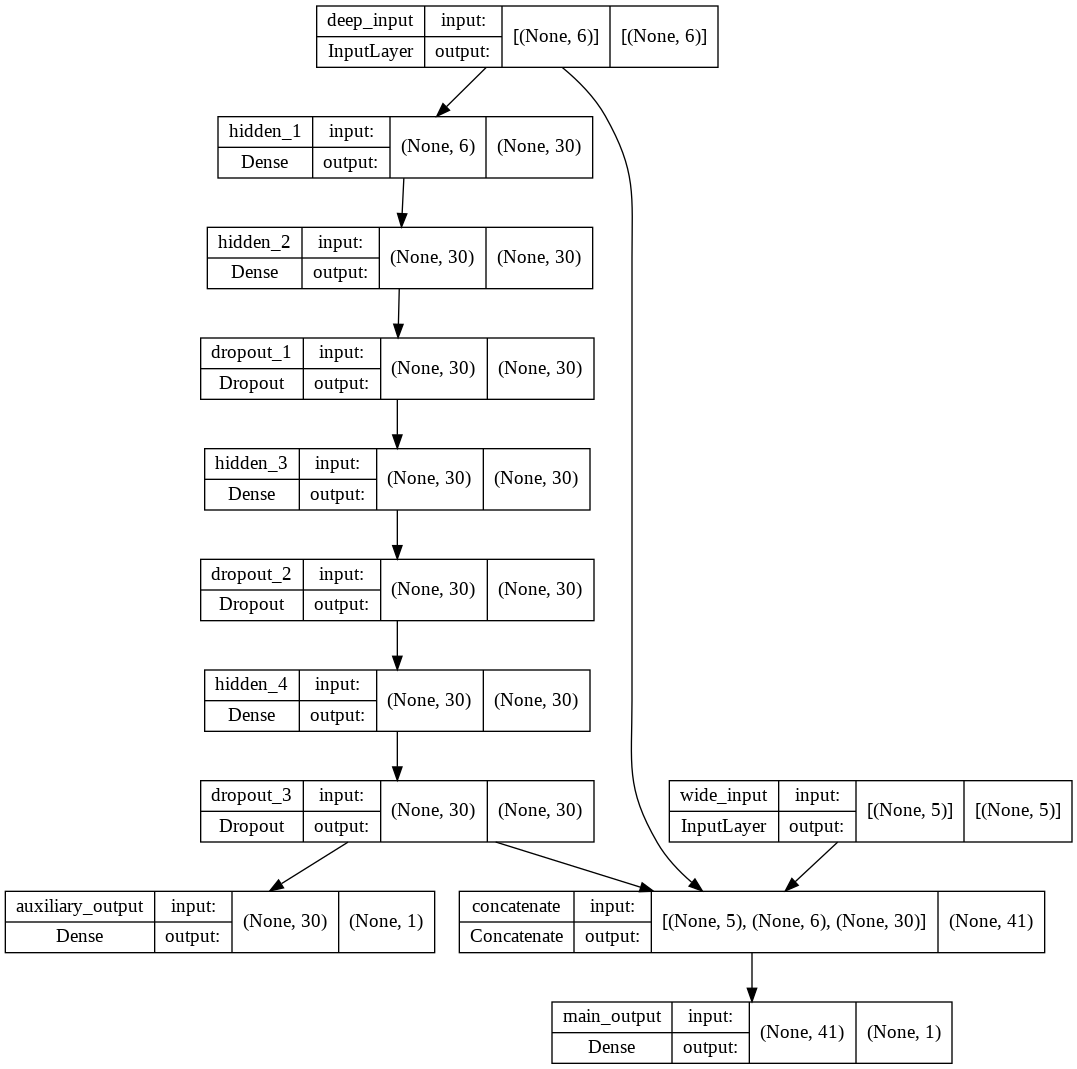

In [9]:
num_hiddens = 4

wide_input_layer = keras.layers.Input(shape = [5], name = 'wide_input') # 5 - for example
deep_input_layer = keras.layers.Input(shape=[6], name = 'deep_input')

hidden_layer = keras.layers.Dense(30, activation = 'relu', name = f'hidden_1')(deep_input_layer)

for i in range(1, num_hiddens):
    hidden_layer = keras.layers.Dense(30, activation='relu', name = f'hidden_{i+1}')(hidden_layer)
    hidden_layer = keras.layers.Dropout(0.2, name = f'dropout_{i}')(hidden_layer)

concat_layer = keras.layers.concatenate([wide_input_layer,deep_input_layer,hidden_layer])
output_layers = keras.layers.Dense(1, name = 'main_output')(concat_layer), keras.layers.Dense(1, name = 'auxiliary_output')(hidden_layer)

model = keras.models.Model(inputs = [wide_input_layer, deep_input_layer],
                           outputs = output_layers)

model.compile(loss=['mae','mse'],
              loss_weights = [0.5,0.6],
              optimizer = keras.optimizers.Adam(learning_rate=1e-3))

plot_model(model, show_shapes = True)

In [11]:
history = model.fit(
    [X['train'][:,:5], X['train'][:,-6:]],
    [y['train'], y['train']],
    validation_split = 0.3,
    epochs = 100,
    batch_size = 64,
    callbacks = [tf.keras.callbacks.EarlyStopping(restore_best_weights=True,patience=10)])

Epoch 1/100
159/159 [==============================] - 2s 5ms/step - loss: 2.0581 - main_output_loss: 1.2385 - auxiliary_output_loss: 2.3981 - val_loss: 0.9018 - val_main_output_loss: 0.6051 - val_auxiliary_output_loss: 0.9987
Epoch 2/100
159/159 [==============================] - 0s 3ms/step - loss: 1.0309 - main_output_loss: 0.7083 - auxiliary_output_loss: 1.1279 - val_loss: 0.6652 - val_main_output_loss: 0.5141 - val_auxiliary_output_loss: 0.6802
Epoch 3/100
159/159 [==============================] - 0s 3ms/step - loss: 0.8216 - main_output_loss: 0.6137 - auxiliary_output_loss: 0.8579 - val_loss: 0.5948 - val_main_output_loss: 0.4927 - val_auxiliary_output_loss: 0.5808
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.7503 - main_output_loss: 0.5652 - auxiliary_output_loss: 0.7796 - val_loss: 0.5355 - val_main_output_loss: 0.4566 - val_auxiliary_output_loss: 0.5120
Epoch 5/100
159/159 [==============================] - 0s 3ms/step - loss: 0.6760 - main_out

In [ ]:
plot_regr_loss(history)

# TensorBoard

In [92]:
keras.backend.clear_session()

root_logdir = os.path.join(os.curdir,'my_logs')

tensorboard_callback = keras.callbacks.TensorBoard(
    get_run_logdir(root_logdir)
    )

print(tensorboard_callback.log_dir)

./my_logs/run_09:30:40_12_03_2022


In [93]:
model = keras.Sequential([
                          keras.layers.Dense(30, activation='relu', input_shape=n_features, kernel_regularizer= keras.regularizers.l1_l2(l1=0,l2=0.01)),
                          keras.layers.Dense(10, activation='relu'),
                          keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=1e-3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(
    X['train'], y['train'],
    epochs = 100,
    batch_size = 64,
    validation_split = 0.3,
    callbacks = [tf.keras.callbacks.TensorBoard(get_run_logdir(root_logdir)), 
                 tf.keras.callbacks.EarlyStopping(restore_best_weights = True, patience=5),
                 tf.keras.callbacks.ModelCheckpoint(filepath=f'{root_logdir}',
                                                    monitor='val_loss',
                                                    mode = 'min',
                                                    save_best_only = True,
                                                    save_weights_only=True)
                 ]
)

Epoch 1/100
159/159 [==============================] - 2s 8ms/step - loss: 3.4855 - val_loss: 1.5953
Epoch 2/100
159/159 [==============================] - 2s 11ms/step - loss: 1.0991 - val_loss: 0.9394
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 0.8375 - val_loss: 0.7829
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 0.7131 - val_loss: 0.6696
Epoch 5/100
159/159 [==============================] - 1s 5ms/step - loss: 0.6228 - val_loss: 0.6074
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5723 - val_loss: 0.5678
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5367 - val_loss: 0.5399
Epoch 8/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5152 - val_loss: 0.5208
Epoch 9/100
159/159 [==============================] - 1s 4ms/step - loss: 0.4964 - val_loss: 0.5083
Epoch 10/100
159/159 [==============================] - 0s 3ms/step - loss: 0.4841 - val_l

In [97]:
# l2(0.01) loss: 0.2989 - val_loss: 0.3391
# l2(0)    loss: 0.3438 - val_loss: 0.3688

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

# Hyperparameter tuning

In [98]:
keras.backend.clear_session()

In [104]:
def build_regr_model(n_hidden = 1, n_units = 30, lr = 1e-3, input_shape=[8], l2_reg_coef = 1e-3):
    model = keras.models.Sequential([
                                     keras.layers.Dense(n_units-i, activation='relu', input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(l2_reg_coef)) for i in range(n_hidden)
                                     ] + [keras.layers.Dense(1)]
    )
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    
    return model

In [107]:
model_params = {
    'n_hidden': 2,
    'n_units': 54,
    'l2_reg_coef': 0.01
}

model = build_regr_model(**model_params)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 54)                486       
                                                                 
 dense_8 (Dense)             (None, 53)                2915      
                                                                 
 dense_9 (Dense)             (None, 1)                 54        
                                                                 
Total params: 3,455
Trainable params: 3,455
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras_reg = KerasRegressor(model=build_regr_model)# Deprecated: keras.wrappers.scikit_learn.KerasRegressor(build_regr_model)
history = keras_reg.fit(X['train'],y['train'],
              batch_size=64,
              epochs = 100,
              validation_split = 0.3,
              callbacks = [keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

history = keras_reg.fit(X['train'],y['train'],
              batch_size=64,
              epochs = 100,
              validation_split = 0.3,
              callbacks = [keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_estimator